<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/signal_detection_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the Signal Detection Theory notebook. After working through this notebook you will be able to...
  * create an ideal observer for a signal detection task
  * simulate the observer's responses 
  * compute d' from the simulated observer using z(hits)-z(false alarms)
  * create a receiver operating characteristic curve
  * calculate the area under the receiver operating characteristic curve and compare to an ideal observers performance on a 2AFC task
  * create an ROC curve from a ratings experiment

  

In [62]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm as progressBar

We're going to simulate a signal detection experiment and an “ideal observer” (an observer who behaves exactly according to signal detection theory). This is always a useful thing to do when trying to understand a decision model, experimental method or an analysis tool. You get to control and play around with the simulation to see what effect it has on the analysis that comes out.

Signal detection is a general framework in which an observer tries to detect the presence or absence of a signal. What's a signal? Anything, really. Signal might be to detect a faint light (can you see whether a candle is lit in a window 1 mile away?). It could be to detect whether you see a friend's face within a crowd. Sometimes these experiments are called “Yes / No” experiments in that the observer has to say either “Yes” I saw it or “No” I did not. Sometimes there is a signal there (the candle was lit, your friend was in the crowd) and these are called signal present trials. Sometimes there is no signal there and those are called signal absent trials.

Subjects are right if the correctly detect a signal when it is present (hit) or when the correctly say the signal absent (correct reject). Similarly, subjects can make two kinds of mistakes - say that the signal was there when it was actually absent (false-alarm) or say that it was not there when it actually was (miss). These kinds of errors have completely unhelpful names in statistics (type 1 or alpha for false-alarm and type 2 or beta for miss), so its more helpful to think about them with these intuitive names!

A key idea that motivates the theory of signal detection is that you want to determine sensitivity (how good are subjects at detecting that faint candle light), but that there is an unaccounted for cognitive factor - what criteria the subject uses. A subject can have a very conservative criteria (only say the light is a candle if you are very sure). This will lower false-alarm rates, but then you may make more misses. A subject alternatively can change their criteria so that they are less prone to missing, but then they will make more false-alarms. Signal detection theory allows you to compute sensitivity and criteria separately from subject responses (i.e. the hit and false-alarm rates) so that you can determine how sensitive a subject is regardless of what arbitrary criteria they used.

For more background, check-out David Heeger's [signal detection theory handouts](httphttp://www.cns.nyu.edu/~david/handouts/sdt/sdt.html).

We will simulate a signal-detection experiment. On each trial, our observer sees an element sampled from either the signal present gaussian distribution or the signal absent distribution, which is also gaussian with the same standard deviation. The observer chooses to say “signal present” when the signal they see on that trial is above criterion and “signal absent” otherwise. The picture you should have in your head is this:

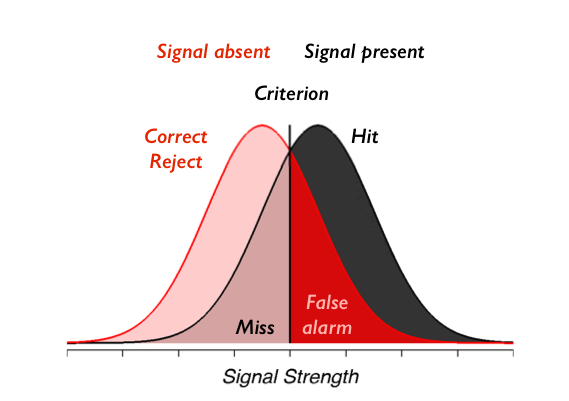

# Make signalPresentAbsent array
So, here goes. First let's make a sequence of n=1000 trials in which 50% randomly are going to have “signal” and 50% are randomly going to have no signal. To do that we want to create an array called signalPresentAbsent that has 1's 50% of the time and 0's 50% of the time. 

In [ ]:
n = 1000; 
signalPresentAbsent = np.random.rand(n)
signalPresentAbsent = np.round(signalPresentAbsent)

#Make signal array
Ok, now we want to simulate the signal that the observer actually gets to base the decision on. Remember that in applying signal detection to cognitive neuroscience you should be thinking of the signal as a neuron or population of neurons response and that the magnitude of this response (e.g. spikes per second) is monotonically related to the actual signal strength. The signal is corrupted by random noise. In particular, signal trials should come from some gaussian distribution and noise trials should come from another gaussian distribution that differ only in the means. This is an assumption about the process that is termed iid - the signal and noise come from independent identical distributions.

Ok, let's make a new array from our signalPresentAbsent array such that on signal present trials (i.e. when signalPresentAbsent == 1) values are picked from a gaussian distribution with standard deviation of 1 who's mean is 1 and on signal absent trails (i.e. when signalPresentAbsent == 0) values are picked from a gaussian distribution with standard deviation of 1 (that's the identical part of the iid assumption) but who's mean is 0.

In [ ]:
signal = np.zeros(n)
# cycle over every trial
for i in range(1,n):
  # if signal present trial
  if signalPresentAbsent[i] == 1:
    # then pull a random draw from the signal distribution with mean = 1 and std = 1
    signal[i] = np.random.normal(loc=1,size=1);
  else:
    # otherwise it is a noise trial so pull a random draw from the noise distribution with mean = 0 and std = 1
    signal[i] = np.random.normal(loc=0,size=1);

Let's take a look at the distribution of signal strengths we have created. 

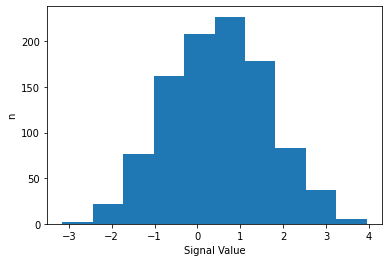

In [ ]:
plt.hist(signal)
plt.xlabel('Signal Value')
plt.ylabel('n');

That's weird, it only has one peak, centered roughly around 0.5. Why? Shouldn't we have one peak at 0 and one peak at 1 for the signal present and absent trials? Yeah, but because they are so close together you can't really see them. You can see them separately if you display the histogram for just the signal present or just the signal absent trials. 

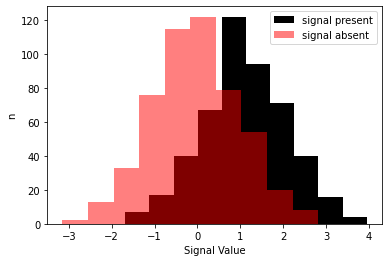

In [ ]:
plt.hist(signal[signalPresentAbsent==1],color=(0, 0, 0))
plt.hist(signal[signalPresentAbsent==0],color=(1, 0, 0, 0.5))
plt.xlabel('Signal Value')
plt.ylabel('n');
plt.legend(('signal present','signal absent'))

Now confirm numerically that the means and standard deviations are what they should be:

In [ ]:
print('Signal present mean: %0.2f +- %0.2f'%(np.mean(signal[signalPresentAbsent==1]),np.std(signal[signalPresentAbsent==1])))
print('Signal absent mean: %0.2f +- %0.2f'%(np.mean(signal[signalPresentAbsent==0]),np.std(signal[signalPresentAbsent==0])))


Signal present mean: 1.09 +- 0.99
Signal absent mean: -0.04 +- 1.01


Ok, we're good to go. We have created the stimulus that our ideal observer will get to see (signal array) and we know which of the trials come from the signal and which from the absent distributions (signalPresentAbsent).

#Make ideal observer responses
Now we are going to simulate an ideal observer which will behave just as signal detection says. They will choose signal present (response=1) when the signal they get to see (signal array from above) is greater than their internal criterion and they will choose signal absent (response=0) when the signal is below their internal criterion.

Let's start by making the criterion right in between the signal present and absent distributions that we created above. That is, let's set criterion=0.5 and make an array of responses. 

In [ ]:
response = signal>0.5

#Calculate hits, misses, correct-rejects and false-alarms
Ok, so now we have our experiment (signalPresentAbsent) a simulation of the signal it generates in the observer (signal) and the ideal observers responses (response).

From these you should be able to calculate hits, misses, correct rejects and false alarms.

In [ ]:
# get total number of present trials
nPresent = np.sum(signalPresentAbsent==1);
# compute hits as all the responses to trials in which signal was present (signalPresentAbsent==1) in which the response was present (i.e. == 1). Divide by number of present trials.
hits = np.sum(response[signalPresentAbsent==1]==1)/nPresent
# misses are the same except when the responses are 0 (absent even though signal was present)
misses = np.sum(response[signalPresentAbsent==1]==0)/nPresent
# same idea for correctRejects and falseAlarms
nAbsent = np.sum(signalPresentAbsent==1);
correctRejects = np.sum(response[signalPresentAbsent==0]==0)/nAbsent
falseAlarms = np.sum(response[signalPresentAbsent==0]==1)/nAbsent

# print values
print('Hits %0.1f%% Misses: %0.1f%% Correct rejects: %0.2f%% False alarms: %0.2f%% '%(100*hits,100*misses,100*correctRejects,100*falseAlarms))

Hits 73.6% Misses: 26.4% Correct rejects: 78.24% False alarms: 30.96% 


Do the proportions of hits, misses, false alarms and correct rejects make sense to you?

#Calculate d'
Now let's calculate d'. But, first a pop quiz: what should d' be given how we made the signal and noise distributions?

 #@d' calculation
 
 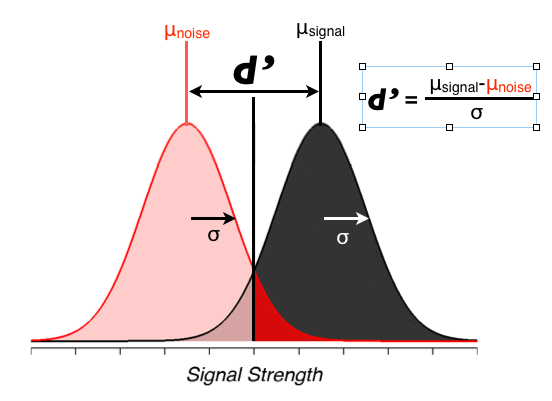

Ok, now we know what it should be, we're ready for pop quiz 2: what's the formula for computing d' from behavioral data?

#@Behavioral d' calculation
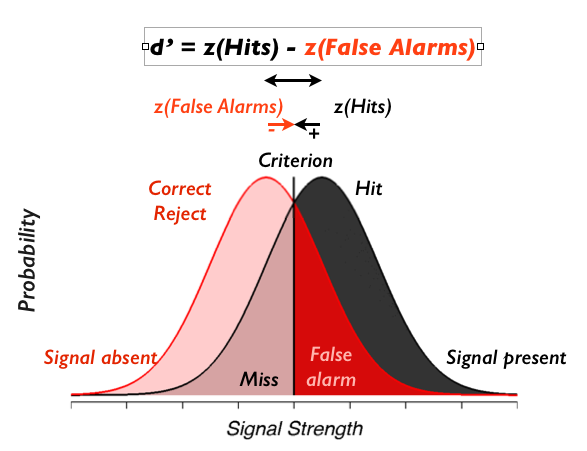

So, how do we calculate those z's?

In [84]:
# Use the ppf function in scipy norm
zHits = norm.ppf(hits)
zFalseAlarms = norm.ppf(falseAlarms)
# compute d'
dPrime = zHits-zFalseAlarms
#display
print('dPrime: %0.1f'%(dPrime))

dPrime: 1.1


#Different criterion
Now, simulate an observer that does not want to miss as much and see if you get a similar d' from their data.

In [89]:
# simulate observer
response = signal>0.4;
# get hits and falseAlarms
hits = sum(response[signalPresentAbsent==1]==1)/nPresent
falseAlarms = sum(response[signalPresentAbsent==0]==1)/nAbsent
# compute z-scores
zHits = norm.ppf(hits)
zFalseAlarms = norm.ppf(falseAlarms)
# compute d-prime
dPrime = zHits-zFalseAlarms
# print
print('dPrime: %0.1f'%(dPrime))

dPrime: 1.1


You can try this for all sorts of criterion, is the d-prime measurement sensitive in any systematic way to the criterion?